# TIME SERIES ANALYSIS FOR DAILY RAINFALL FORECASTING

Dataset1: We have a dataset containing per day rainfall data of several of the cities. The daily precipitation in mm, alongwith Tmin, Tmax and Tavg is given. We will try to make the predictions using the daily precipitation timeseries.

Following code, for basic LSTM model is taken from https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py which is part of the LSTM tutorial : https://www.youtube.com/watch?v=97bZKO6cJfg

NOTE:THIS CODE IS TAKEN AS BASIS TUTORIAL CODE FOR TIME-SERIES ANALYSIS AND IS USED WITH MANY OR FEW MODIFICATIONS/IN FRAGMENTS ACROSS THIS PROJECT

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

#unzip the zip files
!unzip /content/drive/MyDrive/EE769_project/Temperature_And_Precipitation_Cities_IN.zip


Archive:  /content/drive/MyDrive/EE769_project/Temperature_And_Precipitation_Cities_IN.zip
replace Temperature_And_Precipitation_Cities_IN/Bangalore_1990_2022_BangaloreCity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Temperature_And_Precipitation_Cities_IN/Bangalore_1990_2022_BangaloreCity.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Chennai_1990_2022_Madras.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Delhi_NCR_1990_2022_Safdarjung.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Lucknow_1990_2022.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Rajasthan_1990_2022_Jodhpur.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Station_GeoLocation_Longitute_Latitude_Elevation_EPSG_4326.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/weather_Bhubhneshwar_1990_2022.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/weat

In [43]:
  %%capture
# load the dataset
dataframe_yearLong = read_csv('/content/Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv', usecols=[0,4])





#we try to extract only the

dataframe_yearLong['date'] = pd.to_datetime(dataframe_yearLong['time'],infer_datetime_format=True)  #convert time column to datetime format 

mask = (dataframe_yearLong['date'] > '2010-1-1') & (dataframe_yearLong['date'] <= '2014-12-31')  #create mask between selected dates

dataframe_yearLong= dataframe_yearLong.loc[mask]
dataframe_yearLong['prcp'] = dataframe_yearLong['prcp'].fillna(0) #to replace NaN with zero reference: https://datatofish.com/replace-nan-values-with-zeros/
dataframefor_analysis=dataframe_yearLong.copy()
# plt.plot(dataframe_yearLong)
dataframe_yearLong=pd.DataFrame(dataframe_yearLong, columns = ['prcp']  ) #only take prcp column

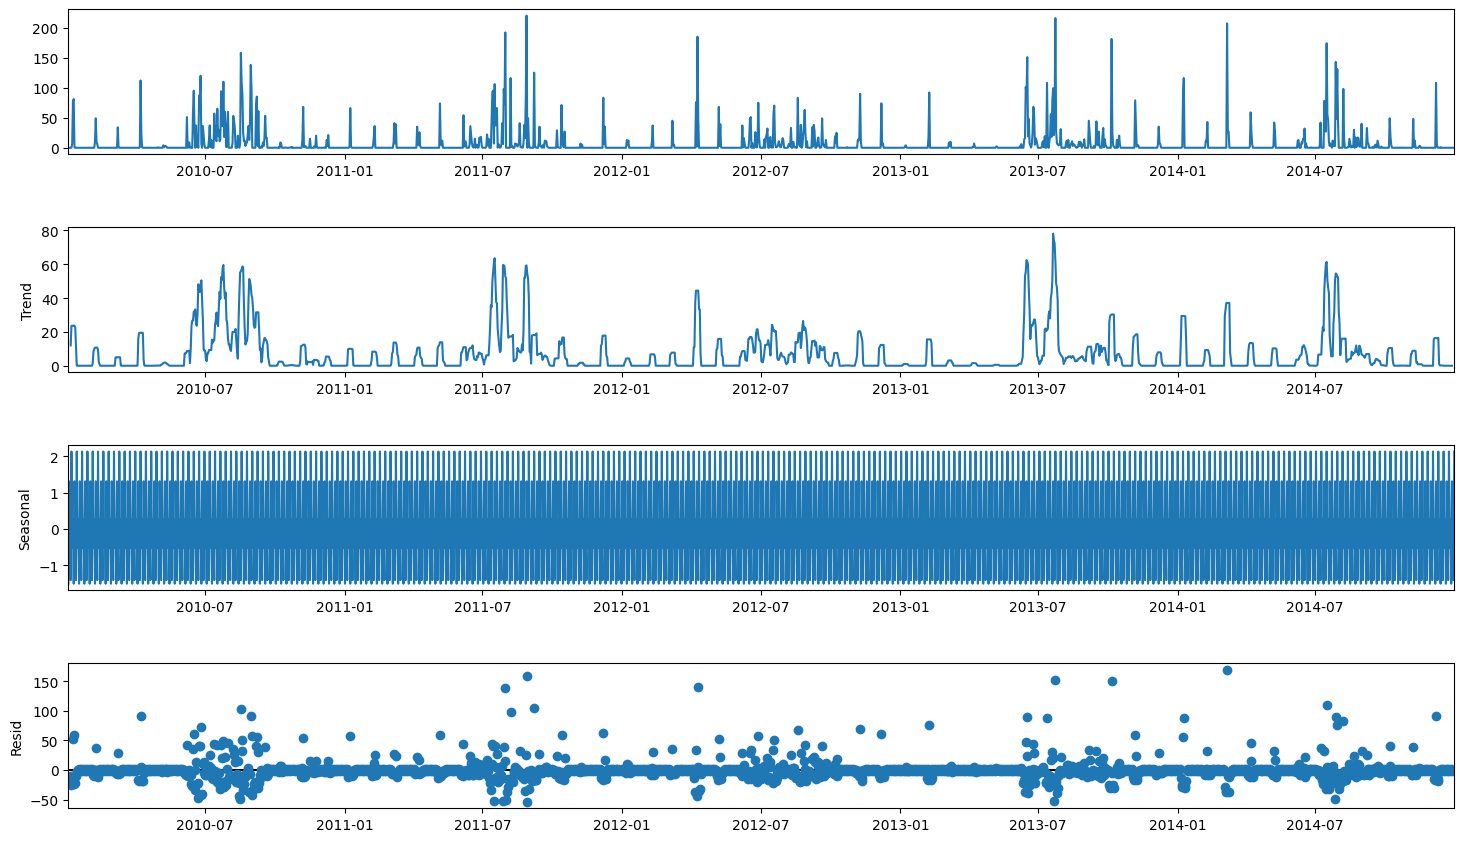

In [44]:
#we try to vizualie the trend and seasonality (code snippet taken from:https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861)

from statsmodels.tsa.seasonal import seasonal_decompose

dataframefor_analysis.set_index('date', inplace=True)
dataframefor_analysis.sort_index(inplace=True)
analysis = dataframefor_analysis[['prcp']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="Additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot().set_size_inches((16, 9)); #reference for resizing https://stackoverflow.com/questions/70377351/statsmodels-api-tsa-seasonal-decompose-plot-figsize

In [45]:
# we need to do the imputation

import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(dataframe_yearLong)

dataframe_yearLong=imp.transform(dataframe_yearLong)
dataframe_yearLong=pd.DataFrame(dataframe_yearLong, columns = ['rainfall']  )     #convert numpy array to dataframe



In [46]:
dataframe_yearLong

,rainfall
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1820,0.0
1821,0.0
1822,0.0
1823,0.0


Shape of training set: (1193, 10)
Shape of test set: (610, 10)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_23 (ConvLSTM2D)  (None, 1, 1, 64)         19200     
                                                                 
 flatten_23 (Flatten)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 32)                2080      
                                                                 
 dense_57 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
38/38 - 5s - loss: 0.0078 - val_loss: 0.0097 - 5s/epoch - 122ms/step
Epoch 2/30
38/38 - 1s - loss: 0.0067 -

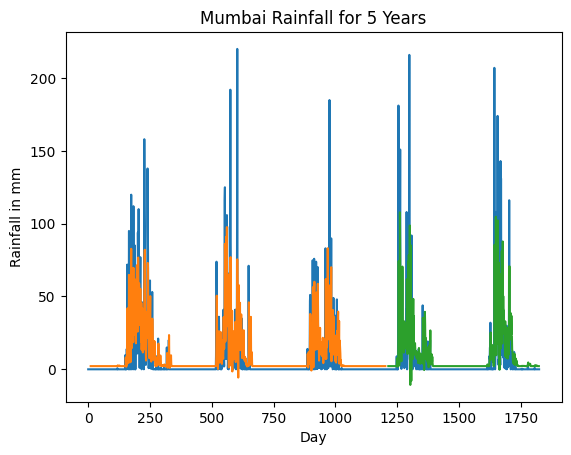

In [47]:

#Convert pandas dataframe to numpy array
dataset = dataframe_yearLong.values
dataset = dataset.astype('float32') #COnvert values to float

#do the transformations to avoid weights blowing up
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.66) #use first 66% data as training data and later 34%data as test/validation data
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# let S is sequence size, it is number of training points we look into past to predict 1 future value

#so for each target value, the training value will be a vector of [S x 1] values, that data formation is done by below function

def to_sequences(dataset, seq_size=1):
    x = []    #input
    y = []    #output

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0] #window of past S values 
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10 

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



#reshape in order to match the shape what LSTM wants

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size))) #64 number of LSTM units
model.add(Flatten())
# Dense neuron layers
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')



###############################################
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=30)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#transform back the scaled values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

#plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Mumbai Rainfall for 5 Years")
plt.xlabel("Day")
plt.ylabel("Rainfall in mm")
plt.show()

Now since in india, the seasonal rains do occur in months of june-september, lets just study them (seasonal rains and see how the prediction goes)

In [48]:

dataframe = read_csv('/content/Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv', usecols=[0,4])

#split the dt into dd mm yyyy cols
# reference:https://www.tutorialspoint.com/write-a-program-in-python-to-split-the-date-column-into-day-month-year-in-multiple-columns-of-a-given-dataframe
dataframe[["dd","mm","yyyy"]] = dataframe["time"].str.split('-',expand=True)
# take only jun,jul,aug,sept data

options = ['06', '07' , '08' ,'09']
  
# selecting rows based on condition
dataframe_seasonal = dataframe.loc[dataframe['mm'].isin(options)]



In [49]:
dataframe_seasonal


,time,prcp,dd,mm,yyyy
151,01-06-1990,22.1,01,06,1990
152,02-06-1990,0.0,02,06,1990
153,03-06-1990,9.1,03,06,1990
154,04-06-1990,0.0,04,06,1990
155,05-06-1990,71.9,05,06,1990
...,...,...,...,...,...
11889,21-07-2022,10.9,21,07,2022
11890,22-07-2022,3.0,22,07,2022
11891,23-07-2022,5.1,23,07,2022
11892,24-07-2022,7.1,24,07,2022


In [50]:
dataframe_seasonal["time"] = pd.to_datetime(dataframe_seasonal["time"])

<ipython-input-50-708db61c3a23>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataframe_seasonal["time"] = pd.to_datetime(dataframe_seasonal["time"])
<ipython-input-50-708db61c3a23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_seasonal["time"] = pd.to_datetime(dataframe_seasonal["time"])


In [51]:
#we only need precipitation column reference:https://www.statology.org/pandas-keep-columns/
dataframe_seasonal.set_index('mm', inplace=True)
dataframe_seasonal = dataframe_seasonal[dataframe_seasonal.columns[dataframe_seasonal.columns.isin(['prcp'])]]


In [52]:
dataframe_seasonal

,prcp
mm,
06,22.1
06,0.0
06,9.1
06,0.0
06,71.9
...,...
07,10.9
07,3.0
07,5.1


In [53]:
#do the imputation
%%capture
imp.fit(dataframe_seasonal)

dataframe_seasonal=imp.transform(dataframe_seasonal)
dataframe_seasonal=pd.DataFrame(dataframe_seasonal, columns = ['rainfall']  ) 

Now lets try and run the model on this dataset

Shape of training set: (2601, 10)
Shape of test set: (1336, 10)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_24 (ConvLSTM2D)  (None, 1, 1, 64)         19200     
                                                                 
 flatten_24 (Flatten)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
82/82 - 6s - loss: 0.0056 - val_loss: 0.0066 - 6s/epoch - 73ms/step
Epoch 2/30
82/82 - 1s - loss: 0.0052 -

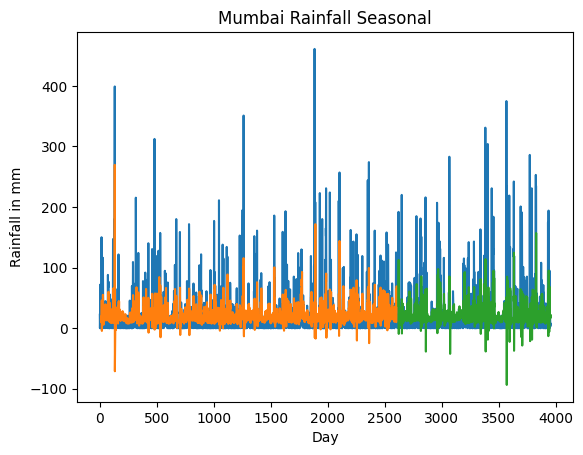

In [54]:
#Convert pandas dataframe to numpy array
dataset = dataframe_seasonal.values
dataset = dataset.astype('float32') #COnvert values to float


scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





seq_size = 10  
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))



trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')



model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=30)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Mumbai Rainfall Seasonal")
plt.xlabel("Day")
plt.ylabel("Rainfall in mm")
plt.show()

We see that the accuracy scores have worsened.

We can Define the function to do RUN the LSTM model and can decide few parameters which we can pass to it so that we can try out for different values of those parameters. These can be

-Data : timeseries data

-Model : the model itself can be parameterized

-seq size: how many past samples to consider to describe future sample

Function would return:

-Training RMSE

-Testing RMSE






Also we can see that the model is making negative predictions, we will clamp them to 0 since they dont make any sense

In [55]:
def run_LSTM( data_frame,mdl,seq_size):
  dataset = data_frame.values
  dataset = dataset.astype('float32') #COnvert values to float


  scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size 
  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  print("Shape of training set: {}".format(trainX.shape))
  print("Shape of test set: {}".format(testX.shape))



  trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
  testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

  model = mdl





  model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=30)




  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
  trainPredict[trainPredict<0] = 0
  testPredict[testPredict<0] = 0


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))


  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.title("Mumbai Rainfall")
  plt.xlabel("Day")
  plt.ylabel("Rainfall in mm")
  plt.show()
  return trainScore,testScore

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_25 (ConvLSTM2D)  (None, 1, 1, 64)         29440     
                                                                 
 flatten_25 (Flatten)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dense_61 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,553
Trainable params: 31,553
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (2561, 50)
Shape of test set: (1296, 50)
Epoch 1/30
81/81 - 5s - loss: 0.0058 - val_loss: 0.0068 - 5s/epoch - 58ms/step
Epoch 2/30
81/81 - 1s - loss: 0.0054 -

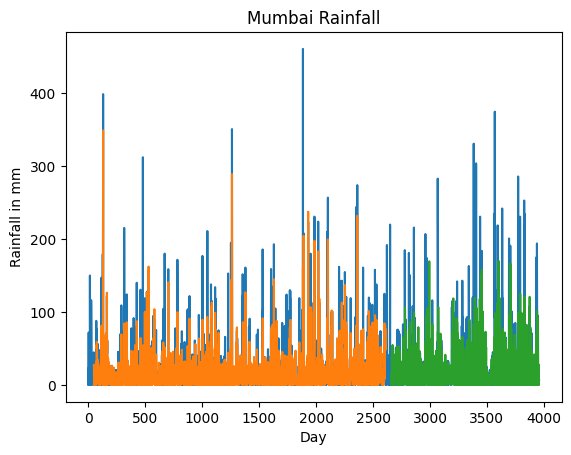

(20.02430114155182, 43.054832773581694)

In [56]:
seq_size=50
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



run_LSTM(dataframe_seasonal,model,seq_size)



We can try for certain values of seq_size and see the trend

In [57]:

%%capture
seqSize=[10,20,30,40,50,60,70,80,90,100]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
  model.add(Flatten())
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  tr,tst = run_LSTM(dataframe_seasonal,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)





In [ ]:
seqSizeTestScore

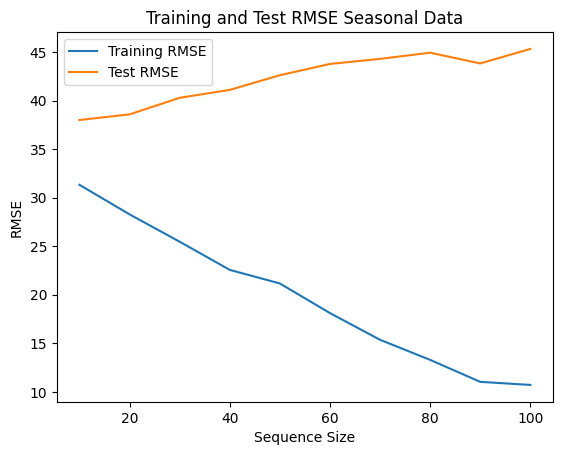

In [58]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Seasonal Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()


We can see that the training RMSE is decreasing, but test RMSE is worsening, this indicates that the model is overfitting on train data but failing on test data

We did this for only seasonal (jun-sept) data, lets rather try for entire year's data.

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_36 (ConvLSTM2D)  (None, 1, 1, 64)         19200     
                                                                 
 flatten_36 (Flatten)        (None, 64)                0         
                                                                 
 dense_82 (Dense)            (None, 32)                2080      
                                                                 
 dense_83 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1193, 10)
Shape of test set: (610, 10)
Epoch 1/30
38/38 - 5s - loss: 0.0074 - val_loss: 0.0093 - 5s/epoch - 123ms/step
Epoch 2/30
38/38 - 1s - loss: 0.0068 -

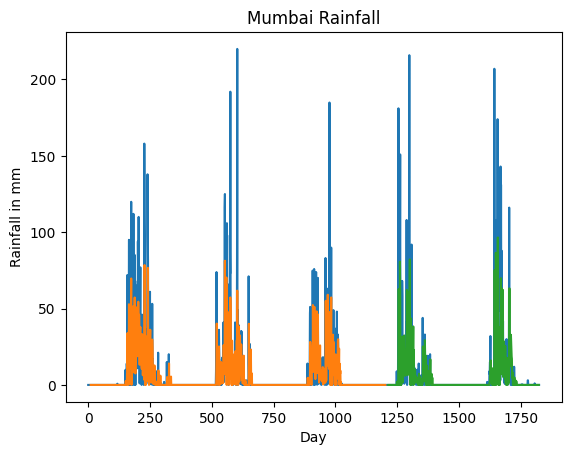

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_37 (ConvLSTM2D)  (None, 1, 1, 64)         21760     
                                                                 
 flatten_37 (Flatten)        (None, 64)                0         
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,873
Trainable params: 23,873
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1183, 20)
Shape of test set: (600, 20)
Epoch 1/30
37/37 - 5s - loss: 0.0079 - val_loss: 0.0100 - 5s/epoch - 143ms/step
Epoch 2/30
37/37 - 0s - loss: 0.0069 -

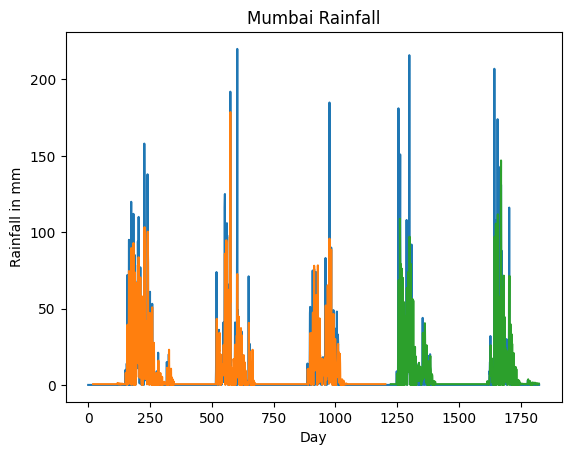

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_38 (ConvLSTM2D)  (None, 1, 1, 64)         24320     
                                                                 
 flatten_38 (Flatten)        (None, 64)                0         
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 dense_87 (Dense)            (None, 1)                 33        
                                                                 
Total params: 26,433
Trainable params: 26,433
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1173, 30)
Shape of test set: (590, 30)
Epoch 1/30
37/37 - 7s - loss: 0.0081 - val_loss: 0.0106 - 7s/epoch - 183ms/step
Epoch 2/30
37/37 - 1s - loss: 0.0070 -

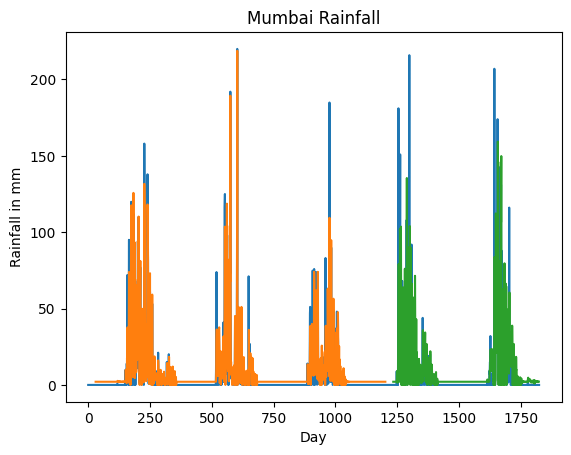

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_39 (ConvLSTM2D)  (None, 1, 1, 64)         26880     
                                                                 
 flatten_39 (Flatten)        (None, 64)                0         
                                                                 
 dense_88 (Dense)            (None, 32)                2080      
                                                                 
 dense_89 (Dense)            (None, 1)                 33        
                                                                 
Total params: 28,993
Trainable params: 28,993
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1163, 40)
Shape of test set: (580, 40)
Epoch 1/30
37/37 - 4s - loss: 0.0080 - val_loss: 0.0105 - 4s/epoch - 117ms/step
Epoch 2/30
37/37 - 0s - loss: 0.0071 -

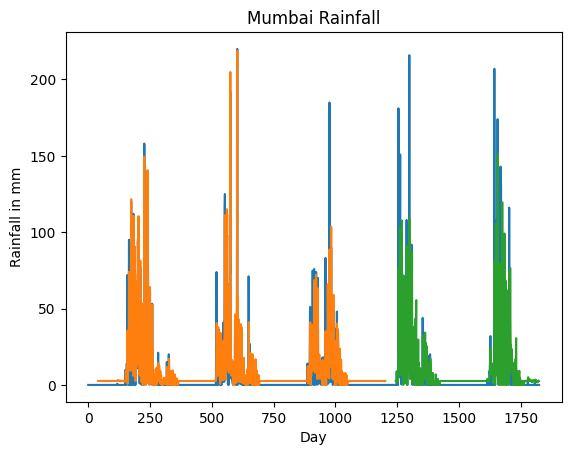

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_40 (ConvLSTM2D)  (None, 1, 1, 64)         29440     
                                                                 
 flatten_40 (Flatten)        (None, 64)                0         
                                                                 
 dense_90 (Dense)            (None, 32)                2080      
                                                                 
 dense_91 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,553
Trainable params: 31,553
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1153, 50)
Shape of test set: (570, 50)
Epoch 1/30
37/37 - 4s - loss: 0.0078 - val_loss: 0.0108 - 4s/epoch - 113ms/step
Epoch 2/30
37/37 - 1s - loss: 0.0072 -

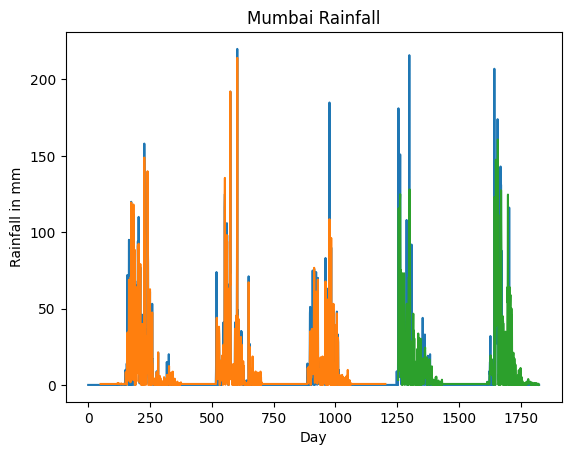

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_41 (ConvLSTM2D)  (None, 1, 1, 64)         32000     
                                                                 
 flatten_41 (Flatten)        (None, 64)                0         
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dense_93 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34,113
Trainable params: 34,113
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1143, 60)
Shape of test set: (560, 60)
Epoch 1/30
36/36 - 4s - loss: 0.0085 - val_loss: 0.0086 - 4s/epoch - 111ms/step
Epoch 2/30
36/36 - 0s - loss: 0.0071 -

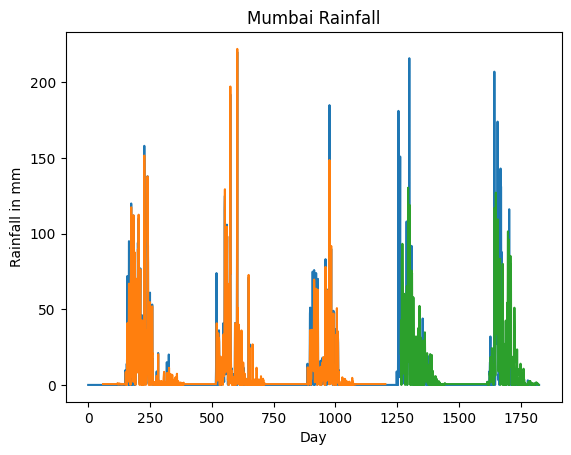

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_42 (ConvLSTM2D)  (None, 1, 1, 64)         34560     
                                                                 
 flatten_42 (Flatten)        (None, 64)                0         
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 1)                 33        
                                                                 
Total params: 36,673
Trainable params: 36,673
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1133, 70)
Shape of test set: (550, 70)
Epoch 1/30
36/36 - 7s - loss: 0.0086 - val_loss: 0.0085 - 7s/epoch - 185ms/step
Epoch 2/30
36/36 - 1s - loss: 0.0071 -

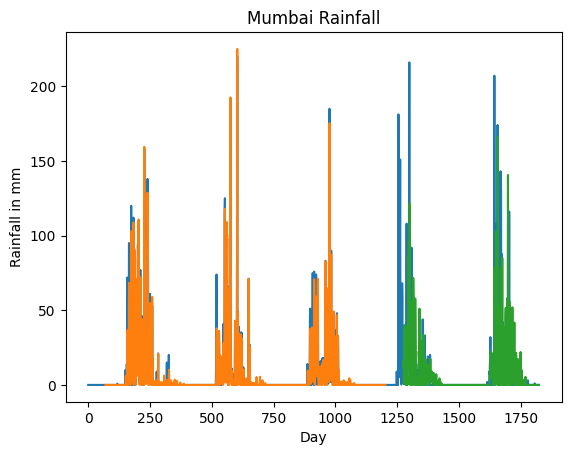

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_43 (ConvLSTM2D)  (None, 1, 1, 64)         37120     
                                                                 
 flatten_43 (Flatten)        (None, 64)                0         
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
Total params: 39,233
Trainable params: 39,233
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1123, 80)
Shape of test set: (540, 80)
Epoch 1/30
36/36 - 4s - loss: 0.0083 - val_loss: 0.0084 - 4s/epoch - 118ms/step
Epoch 2/30
36/36 - 0s - loss: 0.0069 -

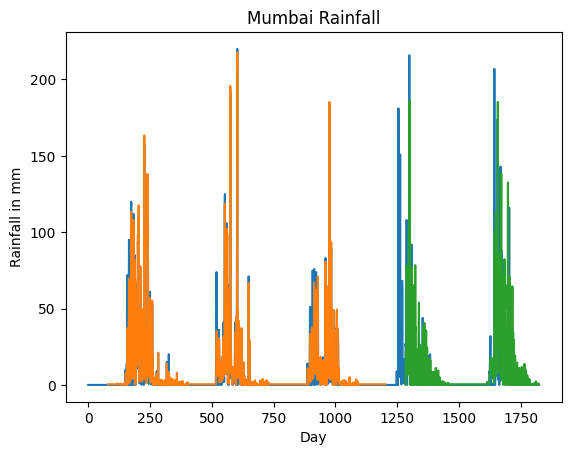

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_44 (ConvLSTM2D)  (None, 1, 1, 64)         39680     
                                                                 
 flatten_44 (Flatten)        (None, 64)                0         
                                                                 
 dense_98 (Dense)            (None, 32)                2080      
                                                                 
 dense_99 (Dense)            (None, 1)                 33        
                                                                 
Total params: 41,793
Trainable params: 41,793
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1113, 90)
Shape of test set: (530, 90)
Epoch 1/30
35/35 - 4s - loss: 0.0080 - val_loss: 0.0087 - 4s/epoch - 118ms/step
Epoch 2/30
35/35 - 0s - loss: 0.0068 -

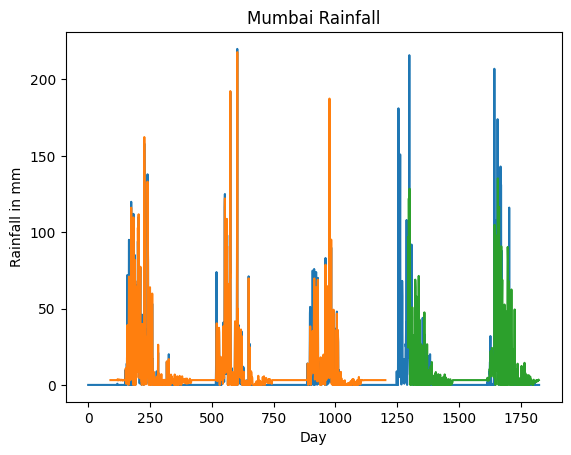

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_45 (ConvLSTM2D)  (None, 1, 1, 64)         42240     
                                                                 
 flatten_45 (Flatten)        (None, 64)                0         
                                                                 
 dense_100 (Dense)           (None, 32)                2080      
                                                                 
 dense_101 (Dense)           (None, 1)                 33        
                                                                 
Total params: 44,353
Trainable params: 44,353
Non-trainable params: 0
_________________________________________________________________
Shape of training set: (1103, 100)
Shape of test set: (520, 100)
Epoch 1/30
35/35 - 5s - loss: 0.0083 - val_loss: 0.0070 - 5s/epoch - 153ms/step
Epoch 2/30
35/35 - 0s - loss: 0.0071

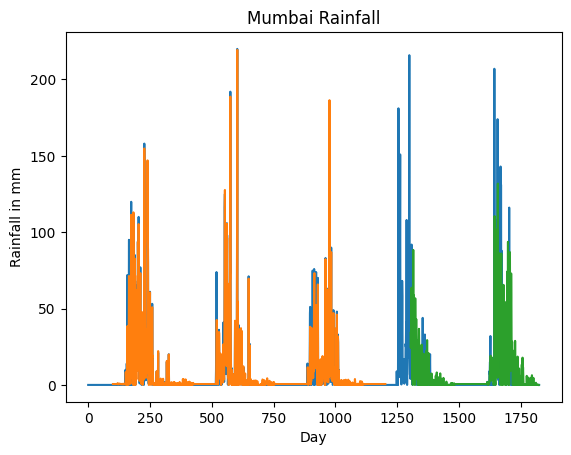

In [59]:
# %%capture
seqSize=[10,20,30,40,50,60,70,80,90,100]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
  model.add(Flatten())
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  tr,tst = run_LSTM(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)



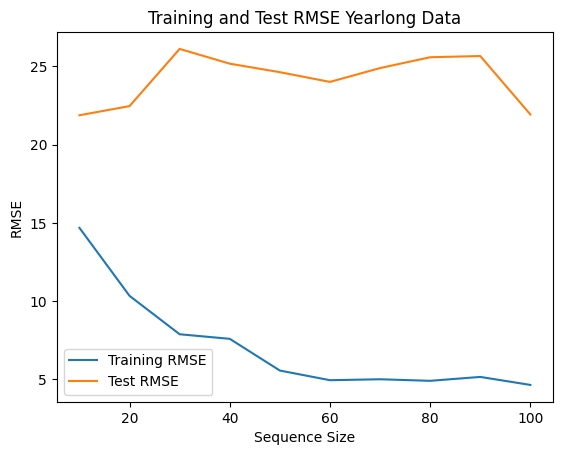

In [60]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

We try with stacked LSTM, we need to change the function since here, the input is in slightly different shape

We stack 2 LSTMs with 32 units each and see the result for various sequence sizes.

In [61]:
def run_LSTM_stacked( data_frame,mdl,seq_size):
  dataset = data_frame.values
  dataset = dataset.astype('float32') #COnvert values to float


  scaler = MinMaxScaler(feature_range=(0, 1)) 
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size  

  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  print("Shape of training set: {}".format(trainX.shape))
  print("Shape of test set: {}".format(testX.shape))



  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  model = mdl





  model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=30)




  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
  trainPredict[trainPredict<0] = 0
  testPredict[testPredict<0] = 0


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))


  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  return trainScore,testScore

In [62]:
%%capture
seqSize=[10,20,30,40,50]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = Sequential()
  model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
  model.add(LSTM(32, activation='relu'))
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.summary()
  tr,tst = run_LSTM_stacked(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)

plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()





In [ ]:
seqSizeTestScore

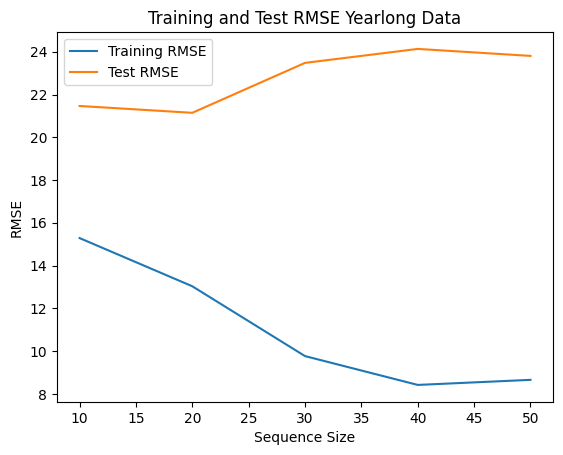

In [63]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

We see the same overfitting result

**SUPPORT VECTOR REGRESSION**


We will try the SVR model where the input size would be N x M where N is number of training points and M would be the sequence size. The output size would be N x 1.

Lets initially try the deafult parameter settings and later we try to look for optimal hyperparameters.

In [64]:
from sklearn.preprocessing import StandardScaler
dataset = dataframe_yearLong.values
dataset = dataset.astype('float32') #COnvert values to float


def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





seq_size = 10 

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))



# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # model = mdl


from sklearn.svm import SVR

model = SVR(kernel='rbf',max_iter=100)


model.fit(trainX, trainY)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict=trainPredict.reshape(-1, 1)
testPredict=testPredict.reshape(-1, 1)


Shape of training set: (1193, 10)
Shape of test set: (610, 10)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Score: 23.03 RMSE
Test Score: 28.20 RMSE


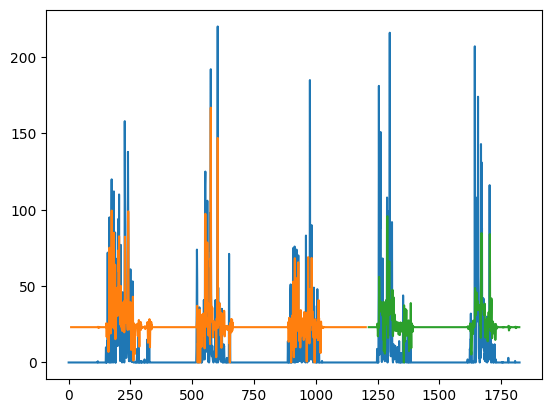

In [65]:

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
trainPredict[trainPredict<0] = 0
testPredict[testPredict<0] = 0


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Like we did with LSTM, we first try to find the best value of seqience size, depending on which, 

We define a function first

In [83]:
def run_model_SVR(data_frame,mdl,seq_size):
  dataset = data_frame.values

  scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
# scaler=StandardScaler()
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size  

  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  model=mdl
  model.fit(trainX, trainY)


# make predictions

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict=trainPredict.reshape(-1, 1)
  testPredict=testPredict.reshape(-1, 1)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
  trainPredict[trainPredict<0] = 0
  testPredict[testPredict<0] = 0


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))

 
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plo
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.title("Rainfall in Mumbai")
  plt.xlabel("Day")
  plt.ylabel("Rainfall in mm")
  plt.show()
  return trainScore,testScore

In [67]:
%%capture
seqSize=[5,10,15,20,25,30,35,40,45,50,55,60]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = SVR(kernel='rbf',max_iter=100)

  
  tr,tst = run_model_SVR(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)



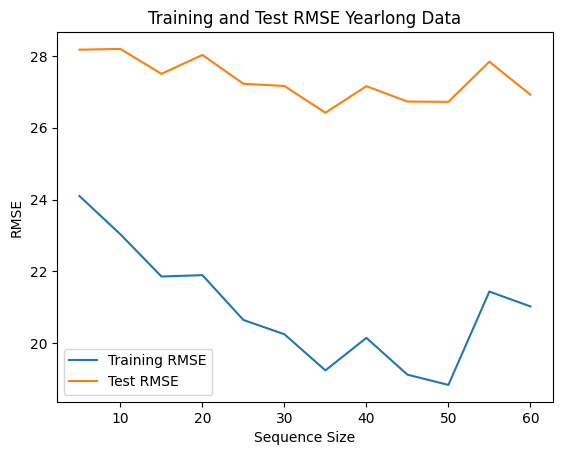

In [68]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

Now we know that 35 is optimal sequence size, we can use it to do the gridsearch and finetune the model.

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-proce

Train Score: 19.27 RMSE
Test Score: 23.87 RMSE


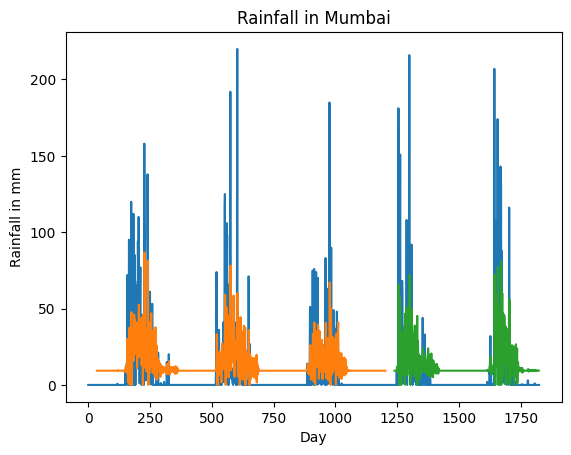

In [85]:
#reference :https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

seq_size=35

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.01,0.1,1, 10],'max_iter':[100,1000,5000]}
svr = SVR()
clf = GridSearchCV(svr, parameters)

tr,tst = run_model_SVR(dataframe_yearLong,clf,seq_size)



In [70]:
clf.best_estimator_

SVR(C=1, kernel='linear', max_iter=100)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Score: 19.27 RMSE
Test Score: 23.87 RMSE


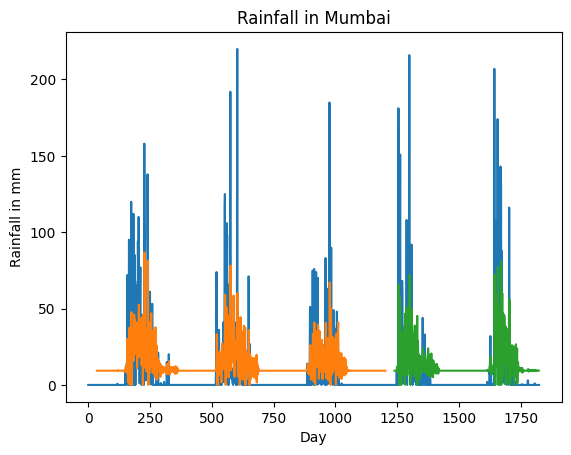

In [86]:
tr,tst = run_model_SVR(dataframe_yearLong,clf.best_estimator_,seq_size)

**TRYING OUT TRANSFORMATIONS OF THE DATA:**

SO far we have been operating directly on the rainfall data of perticular date.
We can try some transformations to  see how it affects our results.

Read about it at: https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/

First we can try taking the  between the rainfall of consucitive days. So rather than training on rainfall we will train and predict for the 'delta' rainfall. 

Small example of difference and inverse difference as shown below

In [72]:
# a= np.array([9,4,8,2,4,12,3,4,6])
a=np.random.randint(10,size=10)
a

array([4, 3, 8, 8, 9, 5, 2, 0, 4, 0])

In [73]:

#take difference
b=a.copy()

for i in range(1,len(b)):
  b[i]=a[i]-a[i-1]

b



array([ 4, -1,  5,  0,  1, -4, -3, -2,  4, -4])

In [74]:
c=b.copy()
for i in range(1,len(b)):
  b[i]=b[i-1]+b[i]
b

array([4, 3, 8, 8, 9, 5, 2, 0, 4, 0])

In [75]:
dataframe_yearLong_diff=dataframe_yearLong.to_numpy()   #convert to numpy array reference:https://www.geeksforgeeks.org/pandas-dataframe-to_numpy-convert-dataframe-to-numpy-array/
dataframe_yearLong_diff_dummy=dataframe_yearLong_diff.copy()
for i in range (0,len(dataframe_yearLong_diff)-1):
  dataframe_yearLong_diff_dummy[i]=dataframe_yearLong_diff[i+1]-dataframe_yearLong_diff[i]

dataframe_yearLong_diff=dataframe_yearLong_diff_dummy



In [76]:
#convert back to dataframe

dataframe_yearLong_diff=pd.DataFrame(dataframe_yearLong_diff, columns = ['rainfall']  )     #convert numpy array to dataframe


Modify the LSTM function to do this transformation and then inverse transformation transform the data back into original form

In [87]:
def run_model_SVR_diffData(data_frame,mdl,seq_size):
  data_frame_orig=data_frame.copy() #preserve original data for later use
  data_frame=data_frame.to_numpy()   #convert to numpy array reference:https://www.geeksforgeeks.org/pandas-dataframe-to_numpy-convert-dataframe-to-numpy-array/
  data_frame_dummy=data_frame.copy()
  for i in range (1,len(data_frame)):
    data_frame_dummy[i]=data_frame[i]-data_frame[i-1]

  data_frame=data_frame_dummy
#convert back to dataframe

  data_frame=pd.DataFrame(data_frame, columns = ['rainfall']  )     #convert numpy array to dataframe


  dataset = data_frame.values
  dataset_orig=data_frame_orig.values
  

  scaler=StandardScaler()
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size 

  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  model=mdl
  model.fit(trainX, trainY)


# make predictions

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict=trainPredict.reshape(-1, 1)
  testPredict=testPredict.reshape(-1, 1)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  

  

  # scaler1 = MinMaxScaler(feature_range=(trainY.min, trainY.max)) #Also try QuantileTransformer
  # trainPredict = scaler1.fit_transform(trainPredict)
  # testPredict = scaler1.fit_transform(testPredict)
  


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))

  # trainPredict_dummy=trainPredict.copy()
  # for i in range(1,len(trainPredict)):
  #   trainPredict_dummy[i]=trainPredict[i-1]+dataset_orig[i-1]
  # testPredict_dummy=testPredict.copy()
  # for i in range(1,len(testPredict)):
  #   testPredict_dummy[i]=testPredict[i-1]+dataset_orig[i-1]

  # trainPredict=trainPredict_dummy
  # testPredict=testPredict_dummy

  # for i in range(1,len(trainPredict)):
  #   trainPredict[i]=trainPredict[i-1]+trainPredict[i]

  # for i in range(1,len(testPredict)):
  #   testPredict[i]=testPredict[i-1]+testPredict[i]

  print(testPredict[:,0])

  
 
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot 
  plt.figure(figsize=(20, 20))
  plt.plot(scaler.inverse_transform(dataset))
  # plt.plot((dataset_orig))
  plt.plot(trainPredictPlot)
  plt.title("One day difference of rainfall")
  plt.xlabel("Day")
  plt.ylabel("One day difference of rainfall in mm")
  plt.plot(testPredictPlot)
  plt.show()
  return trainScore,testScore

Now we can run the LSTM model on it again

In [78]:
%%capture
seqSize=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,120,150,200,250,300]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = SVR(kernel='rbf',max_iter=100)

  
  tr,tst = run_model_SVR_diffData(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)


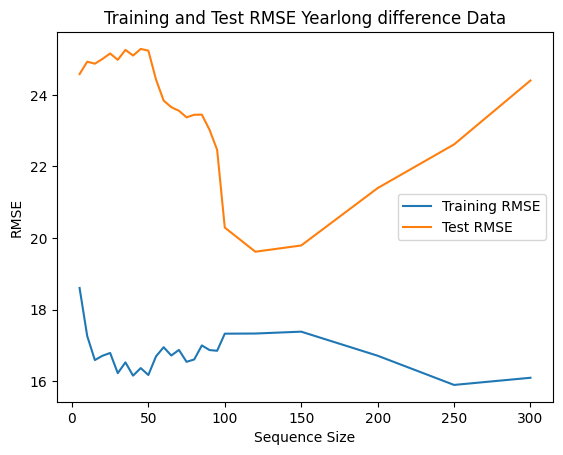

In [79]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong difference Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-proce

Train Score: 19.33 RMSE
Test Score: 18.65 RMSE
[-7.29042959e+00  3.15089100e+00  6.53960010e+00  9.72896621e-01
 -1.22648282e+01  1.10347656e+01 -4.53576262e+00  1.76996439e+00
 -2.07801330e+00 -4.65903170e+00  1.19992846e+00 -2.03727226e+00
 -2.40847480e-01  4.12807143e-01 -5.05035775e+00 -5.68318791e+00
  5.90476948e+00 -2.68056181e+00 -4.33745021e+00  2.78934198e+00
 -3.83980987e+00  8.35393609e+00 -1.95690170e+00 -1.09917030e+01
  1.09526629e-01  3.19481689e+00 -1.01061641e+01  3.53219723e-01
  5.02391635e-01 -3.01062106e+00 -1.90306922e+01  3.82487933e+00
 -1.31142556e+00 -1.36488561e+01  7.29289700e+00 -4.56982282e+00
  7.17690262e+00 -1.78351914e-01 -5.13105271e+00 -3.02134427e+00
  3.50788739e+00 -7.96754659e+00  1.83612115e+00  3.88704526e+00
 -2.21183566e+00  2.66229573e+00  4.21262592e+00  3.28675454e+00
 -2.33524467e+00 -5.36707206e+00  7.05329391e+00 -8.02598006e+00
 -8.08774324e+00  3.55974424e+00 -3.20092665e+00 -3.83500024e+00
  2.09889480e+00 -2.73326764e+00 -1.5297226

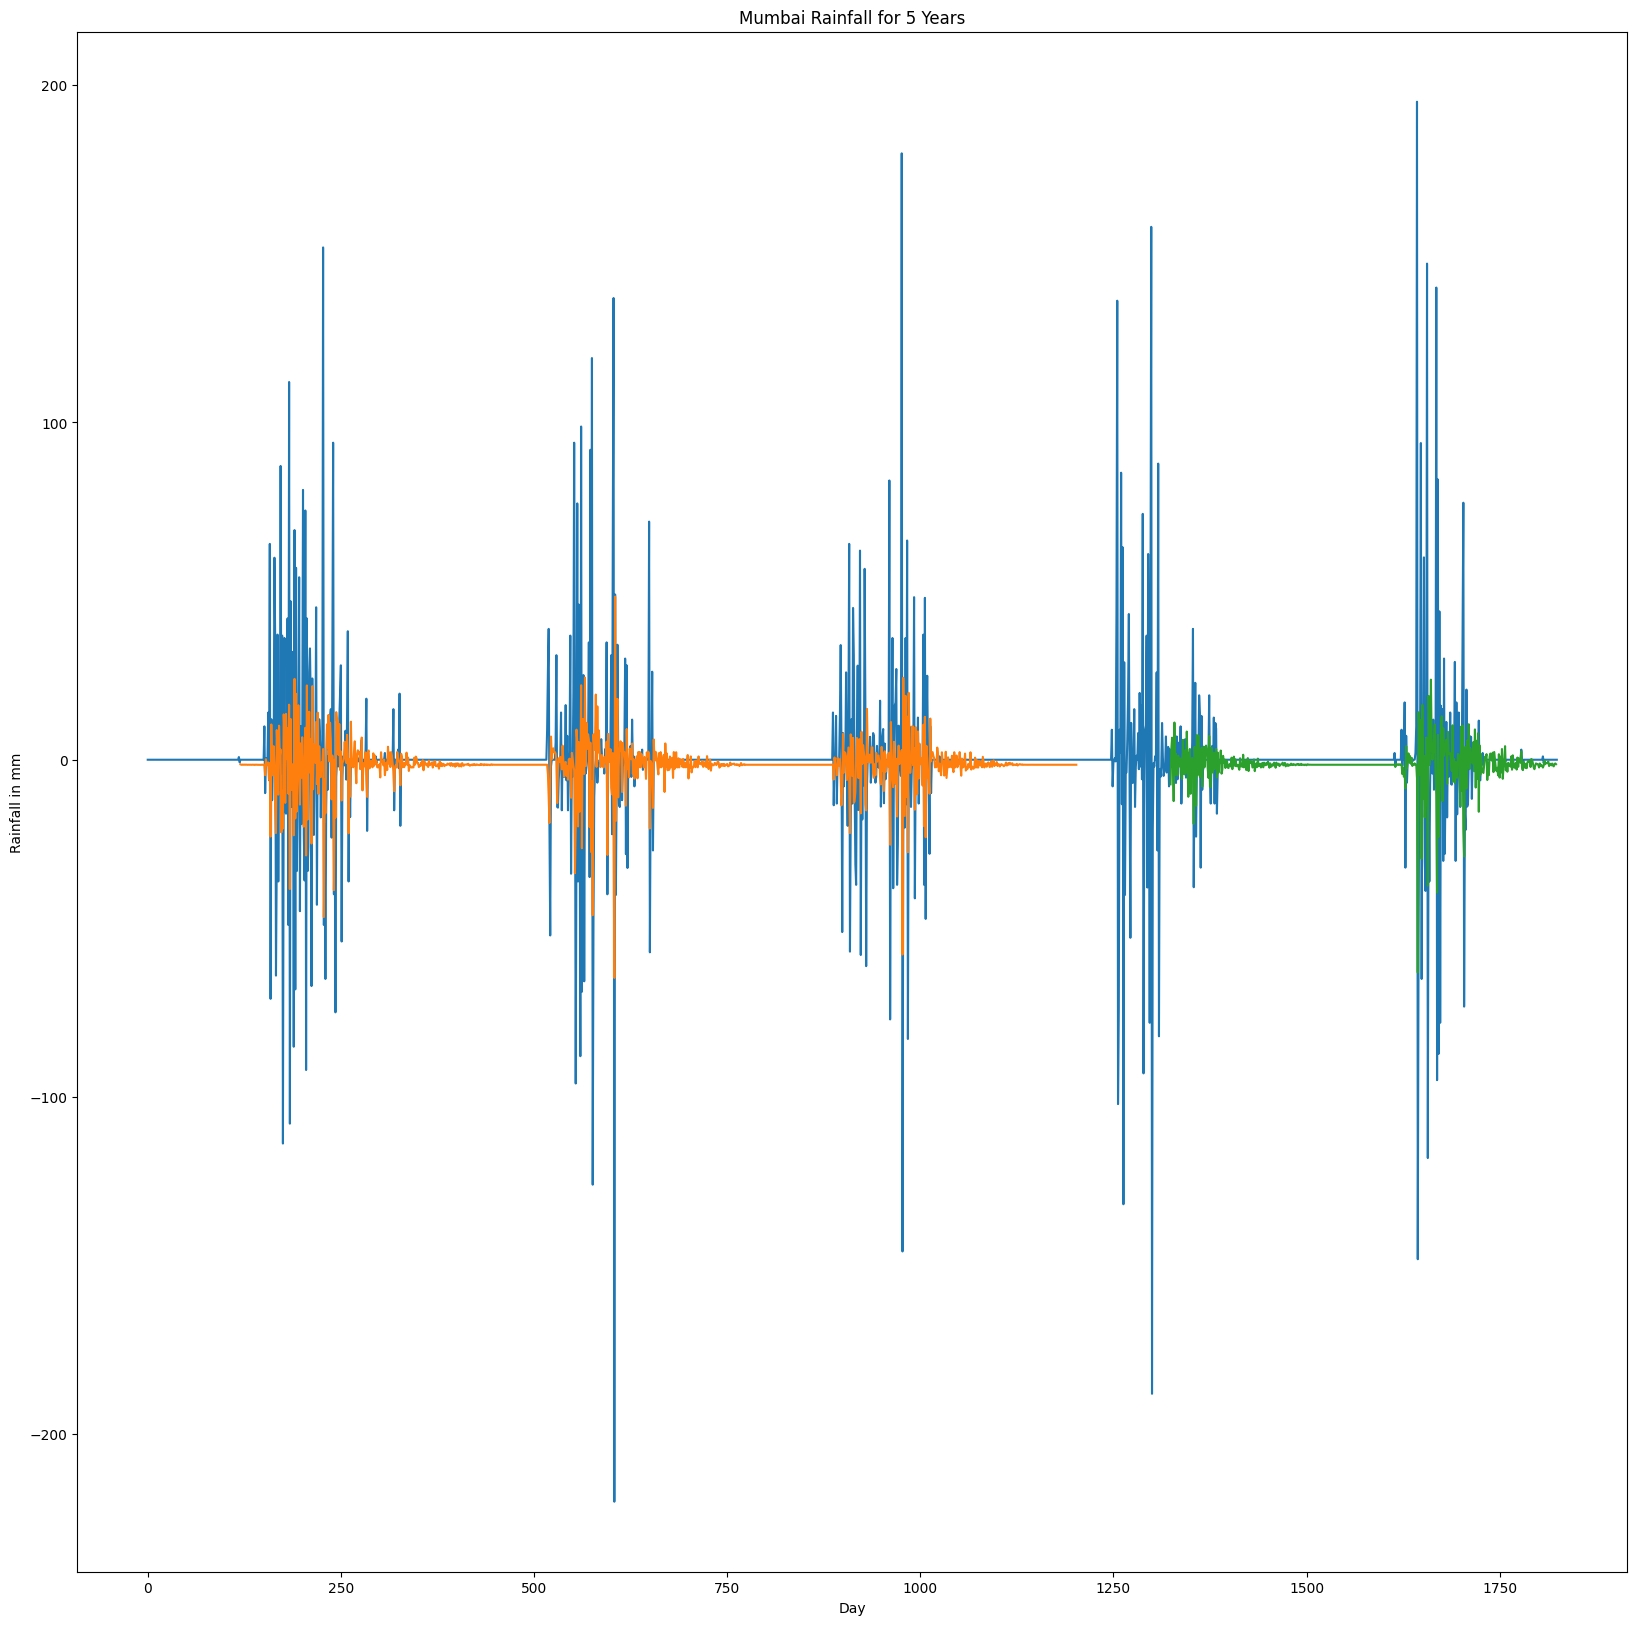

In [80]:
seq_size=120

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.001,0.01,0.1,1, 10],'max_iter':[100,1000,5000]}
svr = SVR()
clf = GridSearchCV(svr, parameters)

tr,tst = run_model_SVR_diffData(dataframe_yearLong,clf,seq_size)


In [81]:
clf.best_estimator_

SVR(C=0.01, kernel='linear', max_iter=5000)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Score: 24.69 RMSE
Test Score: 34.17 RMSE
[-4.56581958e+00 -4.56581958e+00 -4.56581958e+00 -4.56581958e+00
 -4.56581958e+00 -4.56581958e+00 -4.56581958e+00 -4.56581958e+00
 -4.56581958e+00 -4.56581958e+00 -1.24015188e+01 -2.48589796e+00
 -2.98742450e+00 -7.56734861e+00 -3.23359089e+00 -3.24689703e+00
 -4.49455978e+01 -1.50737864e+02 -4.64032907e+00  2.55733219e+01
 -5.43981761e+01  5.96102584e+00 -5.49587358e+01 -6.62562818e+01
 -1.18587462e+02  5.26508724e+01 -1.43881839e+01  2.70870766e+01
  4.16981500e+01 -1.48706171e+01  3.73481060e+01 -2.55162790e+01
  4.84105176e+01 -1.74797237e+01  5.79064619e+01  1.58136845e+01
 -1.73360688e-01  2.99360486e+01  1.67607561e+01  5.90028294e+01
  2.42884973e+01 -4.46995562e+01  1.88939409e+01 -2.10847581e+01
  4.17468054e+01 -2.41508944e+01 -1.69814763e+01  4.64072920e+00
 -9.97082117e+00 -2.57268358e+00 -1.70381914e+02 -2.41727553e+01
  1.56886094e+01  3.77571793e+01  3.82923311e+01 -2.62677363e+01
 -6.83717776e+01 -8.37177584e+01 -5.8785646

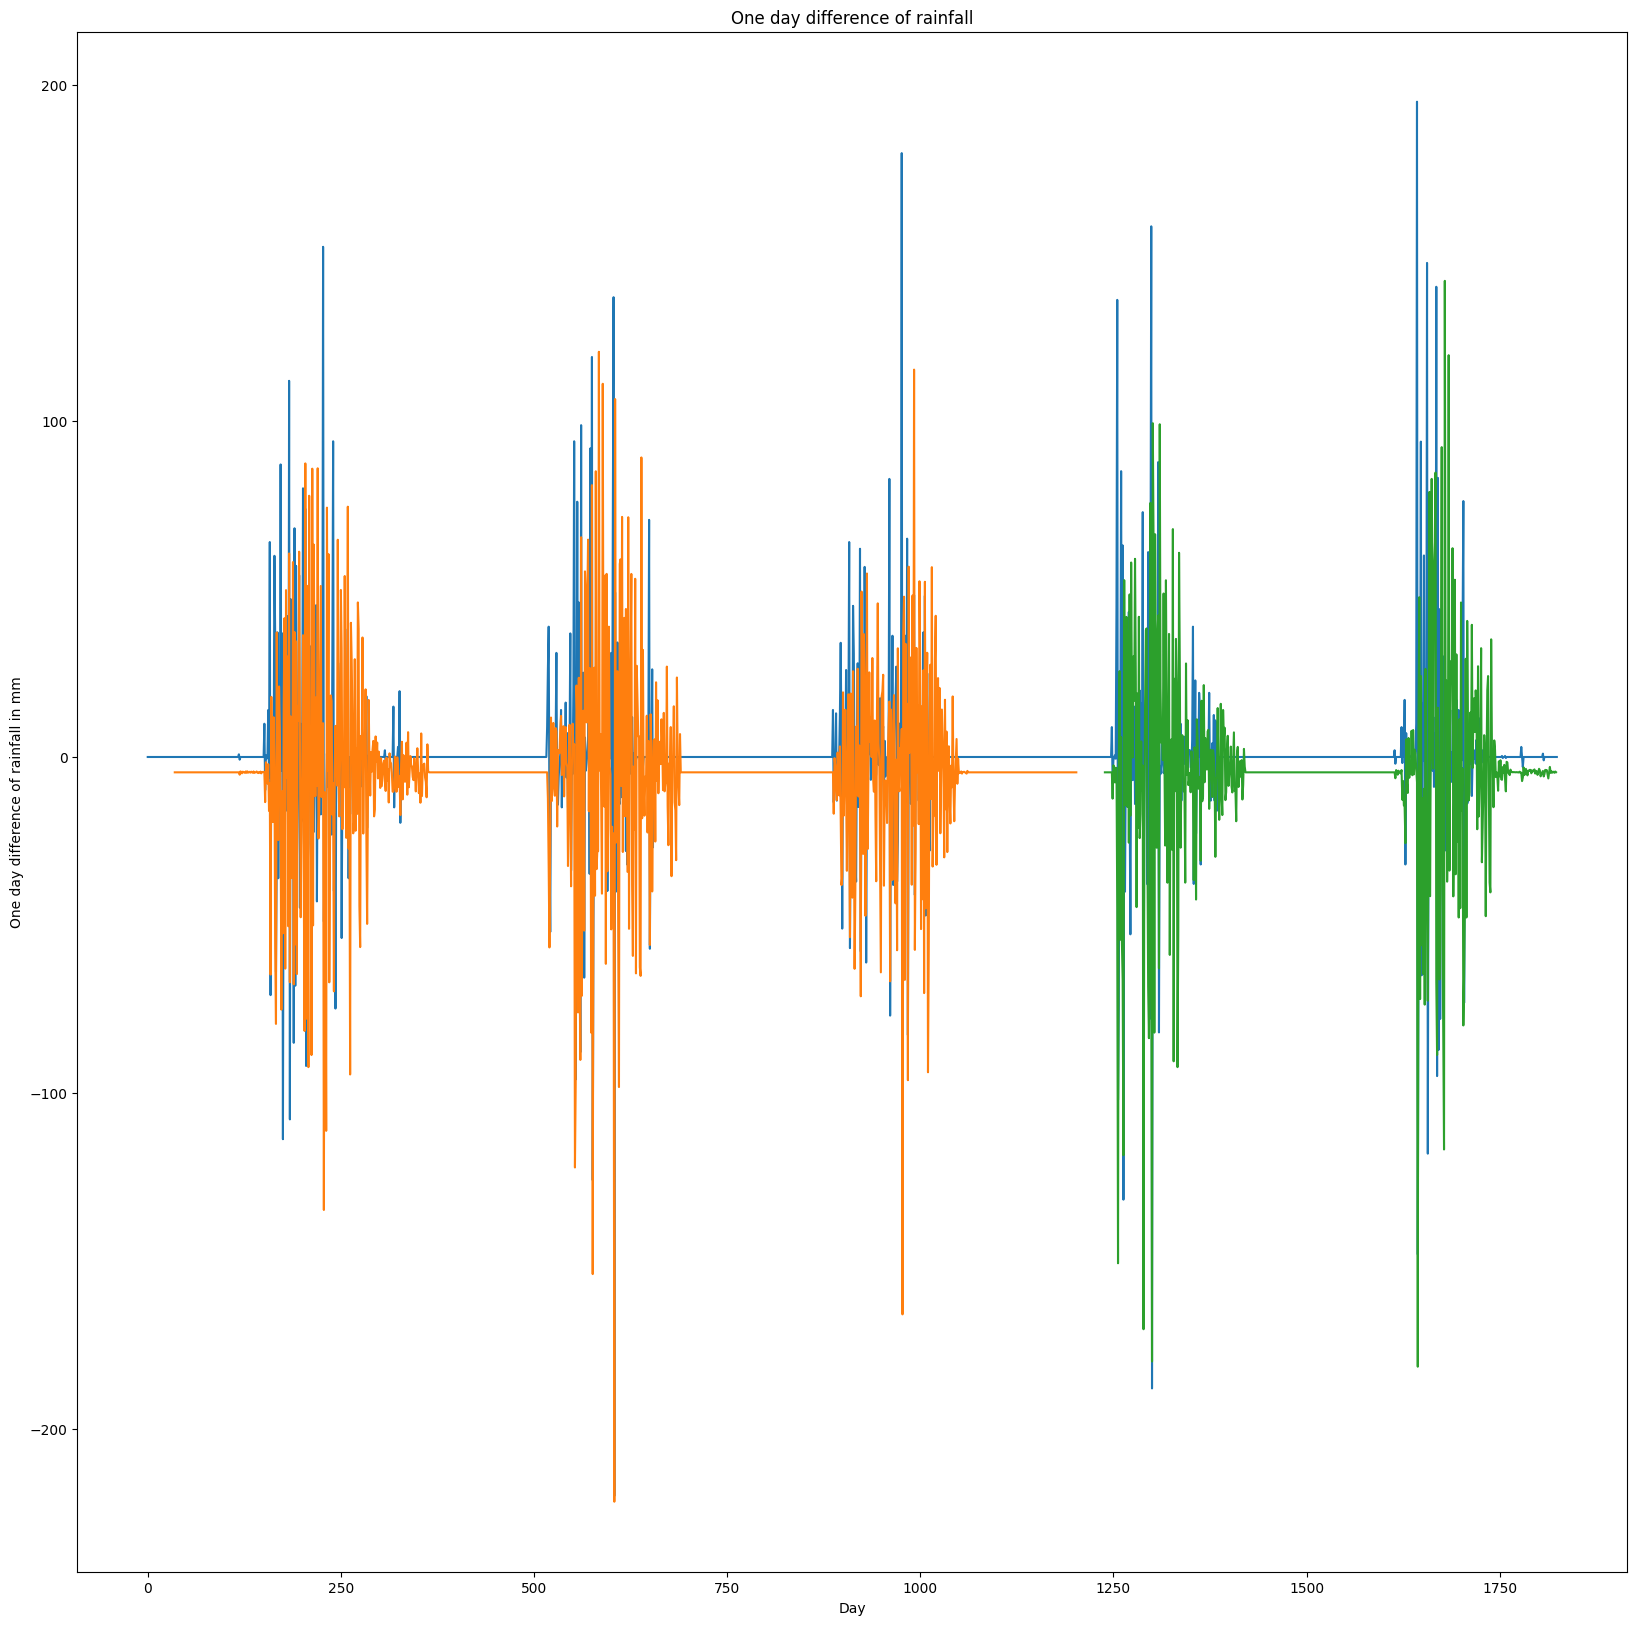

In [88]:
tr,tst = run_model_SVR_diffData(dataframe_yearLong,clf.best_estimator_,seq_size)